# Automatic hyperparameter tuning for machine learning algorithms

Creating machine learning algorithm introduces us with concept of hyperparameters. Tuning hyperparameters is time consuming and can radically influence performance of the algorithm. Choosing right hyperparameter for your model is crucial task that can make model viable solution to a problem and enable it to generalize on different data. Same model with different set of data may require entirely different hyperparameters that will need to be tuned to a problem since we don’t know them beforehand. Given the above hyperparameter optimization is the problem of optimizing a loss function over a configuration space. 

## What are hyperparameters?

Hyperparameters are not model parameters and the can’t be learned from the data in contrast to model parameters. Model parameters are properties of model that will be adjusted during loss function optimization (weights or bias) while hyperparameters are properties of a model that determine who we conduct training process (learning rate, maximum depth of decision tree). 

## Methodology od hyperparameter tuning

There are several approaches for hyperparameter tuning. One of them is manual tuning which in effect takes away time from other steps of machine learning pipeline like feature engineering. This approach is very inefficient and oftentimes is substituted with grid and random search. Those two are automatic but require long run times since they evaluate areas of parameter grid that don’t give good results. Since manual search is taking up human time and grid and random search is time and computationally inefficient new methods have been proposed. 

#### Grid Search      

Grid search is most basic form of hyperparameter optimization, also called parameter sweep. It trains algorithm for all combinations of a manually specified hyperparameter space at the same time measuring performance with some metric (usually used with K-Fold cross validation). One of the drawbacks to performing grid search are fixed parameters in search space which combinations can omit minimum for specific performance metric.

#### Random Search

Random search randomly samples search space and evaluates sets from a specified probability space. Limits exhaustive enumeration of all combinations of random search. It can outperform grid search performance by assuming that in most data sets only a few of the hyperparameters matter.

#### Bayesian Optimisation

Bayesian approach finds extrema of objective function in informed way by keeping track of  previous results. Grid and random search perform every experiment in isolation and every next evaluation is not able to use information from previous runs to improve. Bayesian optimization thanks to record of previous evaluation is able to create a probabilistic model mapping hyperparameters to a probability of a score on the objective function. This model is called surrogate function or response surface. Picking next sample data for evaluation is done by acquisition function. Popular acquisition functions are:

Maximum Probability of Improvement 
- Expected Improvement
- Upper Confidence Bound
- Expected loss criterion


Bayesian optimization belongs to a class of sequential model-based optimization (SMBO) algorithms that allow for one to use the results of our previous iteration to improve our sampling method of the next experiment. Types of SMBO’s differ as well by the choice of surrogate model. Popular surrogate models are:

- Gaussian Processes 
- Random Forest Regressions 
- Tree Parzen Estimators 

### Lets create few evaluations of hyperparameter optimization modules and compare them

In [99]:
############ IMPORTS ################

############ basic imports ##########
import numpy as np
from numpy.random import seed
import pandas as pd
from scipy.stats import randint
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import time

############ model imports ##########
from lightgbm.sklearn import LGBMRegressor

############ metrics ################
from sklearn.metrics import mean_squared_error

############ model select sklearn ##
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

############ basic training data ####
from sklearn.datasets import load_diabetes

############ settings #########
random_state=123
n_iter=50
num_folds=2
verbose=0

############ silient mode ###########
import warnings                         
warnings.filterwarnings('ignore')



########### SEARCH MODULES ##########

########### sklearn search methods ##
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

########### hpsklearn search methods #
from hpsklearn import HyperoptEstimator, xgboost_regression

########### hyperopt search methods###
from hyperopt import fmin, tpe, hp, anneal, Trials

########### skopt search methods #####
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize #gp minimize same as Bayes search
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
########### Handling errors while importing BayesSearch #####
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
########## GPyOpt search methods #####
import GPy
import GPyOpt

########## evolutionary search methods #
from evolutionary_search import EvolutionaryAlgorithmSearchCV

########## btb search methods #########
from btb import HyperParameter, ParamTypes
from btb.tuning import GP, Uniform

######### tpot imports ################
from tpot import TPOTRegressor

######### auto_ml imports #############
from auto_ml import Predictor

In [100]:
######### implemantation of context manager to get time and collect data from different modules ################
class timer:
    def __init__(self, name):
        self.name          = name
        self.cv_score      = None
        self.test_score    = None
        self.object        = None
        self.plot_data     = None
        self.best_params   = None
        
    def __enter__(self):
        self._t0 = time.time()
        print(f'[{self.name}] -- Starting tuning')
        return self
    
    def __exit__(self, *params):
        self.time = time.time() - self._t0
        print(f'[{self.name}] -- Finished tuning')
        if isinstance(self.plot_data, pd.DataFrame):
            self.plot_data['score'] = self.plot_data['score'].astype('float')
            self.plot_data['learning_rate'] = self.plot_data['learning_rate'].astype('float')
            self.plot_data['max_depth'] = self.plot_data['max_depth'].astype('int')
            self.plot_data['n_estimators'] = self.plot_data['n_estimators'].astype('int')
        return None
    
    def __str__(self):
        return f'##################### [{self.name}] ##################### \
        \n \
        \n   evaluated in:          {self.time:.2f} s\
        \n   best cros val MSE was: {self.cv_score:.2f}\
        \n   best test MSE was:     {self.test_score:.2f}\
        \n   best params:           {self.best_params} \n\n'
    
    def print_time(self):
        print(f'[{self.name}] evaluated in {self.time:.2f} s')
        
    def print_summary(self):
        print(self)
        self.plot()
        
    def print_score(self):
        print(f'[{self.name}] best test MSE was {self.test_score:.2f}')
    
    def plot(self):
        if isinstance(self.plot_data, pd.DataFrame):

            print('\n-----------Ploting graphs for searched parameters-----------\n')
            plt.rcParams['font.size'] = 12
            
            fig, axs = plt.subplots(4, 1, figsize = (10, 12))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.lineplot(data=self.plot_data[hyper], ax = axs[i])
                axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper))

            plt.tight_layout()

            fig, axs = plt.subplots(4, 1, figsize = (10, 12))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.kdeplot(self.plot_data[hyper], label = hyper, linewidth = 2, ax = axs[i], shade = True)
                axs[i].set(xlabel = 'Value', ylabel = '{}'.format(hyper), title = '{} distribution'.format(hyper))
                    
            plt.tight_layout()
            
            fig, axs = plt.subplots(1, 4, figsize = (24, 6))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.regplot(x='index', y=hyper, data = self.plot_data.reset_index(), ax = axs[i])
                #sns.lineplot(data=grid_search.plot_data[hyper], ax = axs[i])
                axs[i].set(
                    xlabel = 'Iteration', 
                    ylabel = '{}'.format(hyper), 
                    title = '{} over Search'.format(hyper), 
                    ylim=(self.plot_data[hyper].min() * 0.9 ,self.plot_data[hyper].max() * 1.1)
                )
            plt.tight_layout()
            plt.show()
            
        else:
            print('No plot data')
        

In [101]:
diabetes = load_diabetes()
n = diabetes.data.shape[0]

data = diabetes.data
targets = diabetes.target

# from sklearn.datasets import load_boston
# boston = load_boston()
# data = pd.DataFrame(boston.data)
# data.columns = boston.feature_names
# data['PRICE'] = boston.target
# data, targets = data.iloc[:,:-1],data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(data, targets, 
                                                    test_size=0.20, 
                                                    shuffle=True,
                                                    random_state=random_state
                                                   )

kf = KFold(n_splits=num_folds, random_state=random_state)

In [102]:
eval_array = []

## Basic LightGBM model
This model is trained as reference point without specifying any parameters. It is done in two steps. First we wrap context manager object in function and than call function. Context manager object purpose is to collect time and data about trained model, training steps and scores.

In [103]:
def evaluate_basic_lgbm(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Basic LGBM') as t:
        
        # instantiate LGBM
        model = LGBMRegressor(random_state=random_state)
        
        # assign test score to ccontext object
        t.cv_score = -cross_val_score(
            model, 
            train_data, 
            train_targets, 
            cv=kf, 
            scoring="neg_mean_squared_error", 
            n_jobs=1, 
            verbose=verbose
        ).mean()
        
        # assign best model to context object
        t.object = model.fit(train_data, train_targets)
        # assign test score
        t.test_score = mean_squared_error(test_targets, t.object.predict(test_data))
        t.best_params = t.object.get_params()
    return t

In [104]:
basic_lgbm = evaluate_basic_lgbm()
print(basic_lgbm)
basic_lgbm.plot()

[Basic LGBM] -- Starting tuning
[Basic LGBM] -- Finished tuning
##################### [Basic LGBM] #####################         
         
   evaluated in:          0.10 s        
   best cros val MSE was: 3831.85        
   best test MSE was:     2959.59        
   best params:           {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 1} 


No plot data


## Grid Search
Evaluating standard sklearn GridSearch

In [105]:
def evaluate_gridsearch(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('GridSearch') as t:
        
        model = LGBMRegressor(random_state=random_state)
        
        param_grid={'learning_rate': np.logspace(-3, -1, 3),
                    'max_depth':  np.linspace(2,20, 5,dtype = int),
                    'n_estimators': np.linspace(800,1200, 5, dtype = int),
                    'random_state': [random_state]}

        gs=GridSearchCV(
            model, 
            param_grid, 
            scoring='neg_mean_squared_error', 
            fit_params=None, 
            n_jobs=-1, 
            cv=kf, 
            verbose=verbose
        )
        
        gs.fit(train_data, train_targets)
        t.object = gs
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = -t.object.best_score_
        t.best_params = t.object.best_params_
        
        # get pandas frame of parameter data across iterations of search space
        t.plot_data=pd.DataFrame(np.transpose([-t.object.cv_results_['mean_test_score'],
                                         t.object.cv_results_['param_learning_rate'].data,
                                         t.object.cv_results_['param_max_depth'].data,
                                         t.object.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])     
    return t

In [106]:
eval_array.append(evaluate_gridsearch)

## Random Search
Evaluating sklearn RandomSearch

In [107]:
def evaluate_randomsearch(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('RandomSearch') as t:
        
        model = LGBMRegressor(random_state=random_state, n_jobs=-1)

        param_grid_rand={'learning_rate': np.logspace(-4, 0, 100),
                         'max_depth':  randint(2,20),
                         'n_estimators': randint(100,2000),
                         'random_state': [random_state]}

        rs=RandomizedSearchCV(
            model, 
            param_grid_rand, 
            n_iter = n_iter, 
            scoring='neg_mean_squared_error', 
            fit_params=None, 
            n_jobs=-1, 
            cv=kf, 
            verbose=verbose, 
            random_state=random_state
        )

        rs.fit(train_data, train_targets)
        t.object = rs
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = -t.object.best_score_
        t.best_params = t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([-t.object.cv_results_['mean_test_score'],
                                         t.object.cv_results_['param_learning_rate'].data,
                                         t.object.cv_results_['param_max_depth'].data,
                                         t.object.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [108]:
eval_array.append(evaluate_randomsearch)

In [109]:
# hyperopt objective function
def objective_hyperopt(params, random_state=random_state, cv=kf, X=X_train, y=y_train):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    
    model = LGBMRegressor(random_state=random_state, **params, n_jobs=-1)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [110]:
def evaluate_hyperopt_tpe(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, objective=objective_hyperopt):
    with timer('Hyperopt TPE') as t:

        # defining search space
        space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
               'max_depth' : hp.quniform('max_depth', 2, 20, 1),
               'learning_rate': hp.loguniform('learning_rate', -4, -1)
              }

        # trials will log information about every evaluation
        trials = Trials()

        best=fmin(fn=objective, # function to optimize
                  space=space, 
                  algo=tpe.suggest, # optimization algorithm
                  max_evals=n_iter, 
                  trials=trials,
                  rstate=np.random.RandomState(random_state)
                 )


        model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
        model.fit(train_data, train_targets)
        t.object = model
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = objective(best)
        t.best_params = best
        
        tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

        t.plot_data=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
        
    return t

In [111]:
eval_array.append(evaluate_hyperopt_tpe)

In [112]:
def evaluate_hyperopt_anneal(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, objective=objective_hyperopt):
    with timer('Hyperopt Anneal') as t:
        
        space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
               'max_depth' : hp.quniform('max_depth', 2, 20, 1),
               'learning_rate': hp.loguniform('learning_rate', -4, -1)
              }

       
        trials = Trials()

        best=fmin(fn=objective_hyperopt, 
                  space=space, 
                  algo=anneal.suggest, 
                  max_evals=n_iter, 
                  trials=trials, 
                  rstate=np.random.RandomState(random_state) 
                 )

        # computing the score on the test set
        model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),learning_rate=best['learning_rate'], n_jobs=-1, verbose=1)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = objective(best)
        t.best_params = best
        
        tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

        t.plot_data=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [113]:
eval_array.append(evaluate_hyperopt_anneal)

In [114]:
############## skopt with sklearn api
def evaluate_skopt_bayes(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, optimizer={'base_estimator':'RF', 'acq_func':'PI', 'acq_optimizer':'auto'}):
    with timer('Scikit-Optimize API Bayes') as t:
        
        model = LGBMRegressor(random_state=random_state, n_jobs=-1)
        
        param_grid_bayes={'learning_rate': Real(1e-4, 1e-1, prior='log-uniform'),
                         'max_depth':  Integer(2,20),
                         'n_estimators': Integer(100,2000)
                         }

        bs=BayesSearchCV(model, param_grid_bayes, n_iter = n_iter, scoring='neg_mean_squared_error', fit_params=None, 
                        n_jobs=-1, cv=kf, random_state=random_state, optimizer_kwargs=optimizer)

        bs.fit(train_data, train_targets)

        t.object = bs
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = -t.object.best_score_
        t.best_params = t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([-np.array(t.object.cv_results_['mean_test_score']),
                                         t.object.cv_results_['param_learning_rate'],
                                         t.object.cv_results_['param_max_depth'],
                                         t.object.cv_results_['param_n_estimators']]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [115]:
eval_array.append(evaluate_skopt_bayes)

In [116]:
###########skopt Scikit-Optimize with objective function

In [117]:
space  = [Integer(2, 20, name='max_depth'),
          Real(10**-4, 10**0, "log-uniform", name='learning_rate'),
          Integer(100, 2000, name='n_estimators')]



@use_named_args(space)
def objective_skopt(random_state=random_state, cv=kf, X=X_train, y=y_train,**space):    

    model = LGBMRegressor(random_state=random_state, n_jobs=-1)
    model.set_params(**space)
    
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score

In [118]:
def evaluate_skopt_bayes_dummy(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize dummy minimize') as t:

        res_gp = dummy_minimize(objective_skopt, space, n_calls=n_iter, random_state=random_state)

        # computing the score on the test set
        model = LGBMRegressor(random_state=random_state, n_estimators=int(res_gp.x[2]),
                              max_depth=int(res_gp.x[0]),learning_rate=res_gp.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = res_gp.fun
        t.best_params = {'learning_rate': res_gp.x[1], 'max_depth': int(res_gp.x[0]), 'n_estimators': int(res_gp.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_gp.func_vals),
            np.array(res_gp.x_iters)[:,1], #learning rate
            np.array(res_gp.x_iters)[:,2], #n estimators
            np.array(res_gp.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
    return t

In [119]:
eval_array.append(evaluate_skopt_bayes_dummy)

In [120]:
def evaluate_skopt_bayes_forest(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize forest minimize') as t:

        res_forest = forest_minimize(objective_skopt, space, n_calls=n_iter, random_state=random_state)

        model = LGBMRegressor(random_state=random_state, n_estimators=int(res_forest.x[2]),
                      max_depth=int(res_forest.x[0]),learning_rate=res_forest.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = res_forest.fun
        t.best_params = {'learning_rate': res_forest.x[1], 'max_depth': int(res_forest.x[0]), 'n_estimators': int(res_forest.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_forest.func_vals),
            np.array(res_forest.x_iters)[:,1], #learning rate
            np.array(res_forest.x_iters)[:,2], #n estimators
            np.array(res_forest.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
    return t

In [121]:
eval_array.append(evaluate_skopt_bayes_forest)

In [122]:
def evaluate_skopt_bayes_gbrt(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize gbrt minimize') as t:

        res_gbrt = gbrt_minimize(objective_skopt, space, n_calls=n_iter, random_state=random_state)

        model = LGBMRegressor(random_state=random_state, n_estimators=int(res_gbrt.x[2]),
                      max_depth=int(res_gbrt.x[0]),learning_rate=res_gbrt.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = res_gbrt.fun
        t.best_params = {'learning_rate': res_gbrt.x[1], 'max_depth': int(res_gbrt.x[0]), 'n_estimators': int(res_gbrt.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_gbrt.func_vals),
            np.array(res_gbrt.x_iters)[:,1], #learning rate
            np.array(res_gbrt.x_iters)[:,2], #n estimators
            np.array(res_gbrt.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
    return t

In [123]:
eval_array.append(evaluate_skopt_bayes_gbrt)

In [124]:
######### GPyOpt

In [125]:
seed(random_state)

domain =[{'name': 'max_depth',   'type': 'discrete', 'domain': np.linspace(2,20, dtype=int)},
       {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 1)},
       {'name': 'n_estimators',  'type': 'discrete', 'domain': np.linspace(100,2000, dtype=int)}
      ]


def bayes_lgbm_gpy(x, mdl=None, cv=None):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0], 1))
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
        dict_params['max_depth'] = int(dict_params['max_depth'])
        dict_params['n_estimators'] = int(dict_params['n_estimators'])
        #print(dict_params)
        mdl.set_params(**dict_params)
        fs[i] = -cross_val_score(mdl, X_train, y_train, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    return fs


def evaluate_gpyopt(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('GPyOpt') as t:
        opt = GPyOpt.methods.BayesianOptimization(f = partial(bayes_lgbm_gpy, mdl=LGBMRegressor(random_state=random_state, n_jobs=-1), cv=kf),       
                                                  domain = domain,         # box-constrains of the problem
                                                  model_type= 'GP',
                                                  acquisition_type='EI',
                                                  num_cores=8,
                                                  #acquisition_weight = 0.01
                                                 )  
        # https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html?highlight=acquisition_type
        opt.run_optimization(max_iter=n_iter)
        
        model = LGBMRegressor(random_state=random_state, n_estimators=int(opt.x_opt[2]),
                      max_depth=int(opt.x_opt[0]), learning_rate=opt.x_opt[1], n_jobs=-1, verbose=1)
        t.object = model
        t.object.fit(train_data,train_targets)
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score = opt.fx_opt
        t.best_params = {'learning_rate': opt.x_opt[1], 'max_depth': int(opt.x_opt[0]), 'n_estimators': int(opt.x_opt[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(opt.Y)[:,0],
            np.array(opt.X)[:,1], #learning rate
            np.array(opt.X)[:,2], #n estimators
            np.array(opt.X)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [126]:
eval_array.append(evaluate_gpyopt)

In [127]:
seed(random_state)

param_grid={'learning_rate': np.logspace(-5, -1, 300),
            'max_depth':  np.linspace(2, 20, 20-1, dtype = int),
            'n_estimators': np.linspace(100 ,2000, 2000-100, dtype = int),
            'random_state': [random_state]}

# print("Size: ", len(param_grid["learning_rate"])*len(param_grid["max_depth"])*len(param_grid["n_estimators"]))
def evaluate_evolutionary(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Evolutionary Algorithm Search') as t:
        model = LGBMRegressor(random_state=random_state, n_jobs=-1)
        evol=EvolutionaryAlgorithmSearchCV(model, 
                                           param_grid, 
                                           scoring='neg_mean_squared_error', 
                                           fit_params=None, 
                                           n_jobs=1, 
                                           cv=kf, 
                                           verbose=verbose, 
                                           population_size=15,
                                           gene_mutation_prob=0.60,
                                           gene_crossover_prob=0.5,
                                           tournament_size=3,
                                           generations_number=10)


        evol.fit(train_data, train_targets)
        t.object = evol
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))
        t.cv_score=-t.object.best_score_
        t.best_params=t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([-np.array(evol.cv_results_['mean_test_score']),
                                         [item['learning_rate'] for item in evol.cv_results_['params']],
                                         [item['max_depth'] for item in evol.cv_results_['params']],
                                         [item['n_estimators'] for item in evol.cv_results_['params']]]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])    
    return t

In [128]:
eval_array.append(evaluate_evolutionary)

In [129]:
seed(random_state)
tunables = [
    ('n_estimators', HyperParameter(ParamTypes.INT, [100, 2000])),
    ('max_depth', HyperParameter(ParamTypes.INT, [2, 20])),
    ('learning_rate', HyperParameter(ParamTypes.FLOAT_EXP, [0.0001, 1]))
]

def evaluate_btb(tuner=GP(tunables), train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('BTB') as t:

    #def tune_lgbm(tuner, random_state=random_state, cv=kf, X=train_data, y=train_targets):
        for i in range(n_iter):
            params = tuner.propose()

            model = LGBMRegressor(random_state=random_state, 
                                  n_jobs=-1,
                                  n_estimators=params['n_estimators'],
                                  max_depth=params['max_depth'],
                                  learning_rate=params['learning_rate']
                                 )

            score = cross_val_score(model, train_data, train_targets, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1).mean()
            tuner.add(params, score)
            
            
        model = LGBMRegressor(random_state=random_state, n_estimators=tuner._best_hyperparams['n_estimators'],
                      max_depth=tuner._best_hyperparams['max_depth'],learning_rate=tuner._best_hyperparams['learning_rate'], n_jobs=-1, verbose=1)
        model.fit(train_data,train_targets)
        t.object = model
        t.cv_score = -tuner._best_score
        t.best_params = tuner._best_hyperparams
        t.test_score=mean_squared_error(test_targets, t.object.predict(test_data))    
        t.plot_data=pd.DataFrame(np.transpose([-np.array(tuner.y),
                                         10**tuner.X[:,2],
                                         tuner.X[:,1],
                                         tuner.X[:,0]]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
    return t

In [130]:
eval_array.append(evaluate_btb)

In [131]:
for i, f in enumerate(eval_array):
    func = f()
    print(func)
    eval_array[i] = func

[GridSearch] -- Starting tuning
[GridSearch] -- Finished tuning
##################### [GridSearch] #####################         
         
   evaluated in:          6.67 s        
   best cros val MSE was: 3438.89        
   best test MSE was:     2523.14        
   best params:           {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 800, 'random_state': 123} 


[RandomSearch] -- Starting tuning
[RandomSearch] -- Finished tuning
##################### [RandomSearch] #####################         
         
   evaluated in:          4.58 s        
   best cros val MSE was: 3413.94        
   best test MSE was:     2750.58        
   best params:           {'learning_rate': 0.002848035868435802, 'max_depth': 2, 'n_estimators': 1332, 'random_state': 123} 


[Hyperopt TPE] -- Starting tuning
[Hyperopt TPE] -- Finished tuning
##################### [Hyperopt TPE] #####################         
         
   evaluated in:          6.53 s        
   best cros val MSE was: 3473.88     

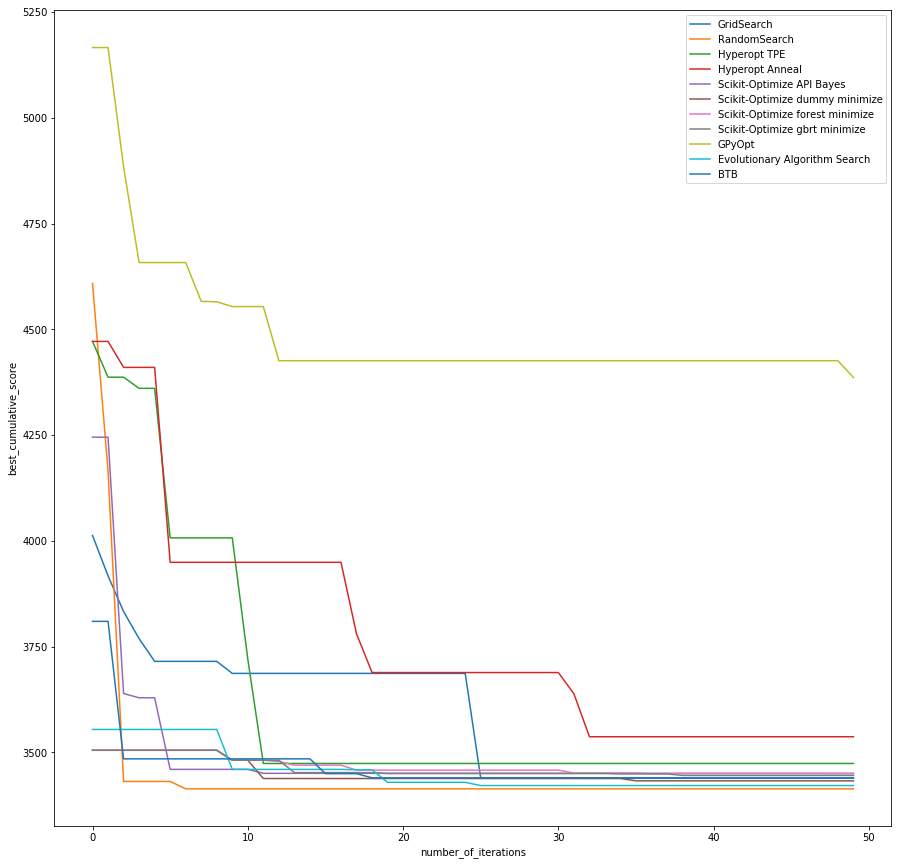

In [132]:
scores_df=pd.DataFrame(index=range(n_iter))
for elm in eval_array:
    scores_df[elm.name] = elm.plot_data['score'].cummin()

ax = scores_df.plot(figsize=(15, 15))

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")
plt.show()

In [133]:
print('Test MSE scored:')
for elm in eval_array:
    print("{} - {:.3f}".format(elm.name, elm.test_score))

Test MSE scored:
GridSearch - 2523.141
RandomSearch - 2750.581
Hyperopt TPE - 2777.769
Hyperopt Anneal - 2694.643
Scikit-Optimize API Bayes - 2706.230
Scikit-Optimize dummy minimize - 2636.697
Scikit-Optimize forest minimize - 2714.055
Scikit-Optimize gbrt minimize - 2679.641
GPyOpt - 3506.660
Evolutionary Algorithm Search - 2759.086
BTB - 2674.263


In [134]:
stat_frame = pd.DataFrame(columns=['module', 'time', 'mean_score', 'max_score', 'min_score', 'std_score', 'best_test_score'])
stat_frame = stat_frame.append(
    pd.DataFrame(
        [[elm.name, 
          elm.time, 
          elm.plot_data['score'].mean(), 
          elm.plot_data['score'].max(), 
          elm.plot_data['score'].min(), 
          elm.plot_data['score'].std(),
          elm.test_score] for elm in eval_array], 
        columns=['module', 'time', 'mean_score', 'max_score', 'min_score', 'std_score', 'best_test_score']
    )
)
stat_frame.sort_values('best_test_score')

,module,time,mean_score,max_score,min_score,std_score,best_test_score
0,GridSearch,6.673160,4029.866516,4596.657380,3438.887311,356.777234,2523.140865
5,Scikit-Optimize dummy minimize,7.493732,4149.902876,5567.267032,3432.740060,591.714643,2636.696703
10,BTB,3.892791,4267.949820,5483.298115,3439.895488,610.822699,2674.262659
7,Scikit-Optimize gbrt minimize,9.886046,3835.557352,5536.792532,3445.595057,598.237049,2679.640941
3,Hyperopt Anneal,4.424322,4044.759981,4620.078719,3537.089592,272.548183,2694.643487
4,Scikit-Optimize API Bayes,30.856599,3609.819929,5341.096304,3450.590099,408.356173,2706.229847
6,Scikit-Optimize forest minimize,12.147161,3761.765738,5536.792532,3449.772499,539.017159,2714.055111
1,RandomSearch,4.584404,4259.892297,5701.840470,3413.942217,607.425657,2750.581122
9,Evolutionary Algorithm Search,20.931032,3468.553817,4320.988796,3421.702061,124.700322,2759.086266
2,Hyperopt TPE,6.531447,4184.970193,4631.380250,3473.879946,360.459850,2777.768522


In [41]:
# %%time

# estim = HyperoptEstimator(regressor=xgboost_regression('my_gb'), max_evals=n_iter, trial_timeout=60, seed=random_state)

# estim.fit(train_data, train_targets)

# print(mean_squared_error(test_targets, estim.predict(test_data)))

In [42]:
######### tpot

In [43]:
tpot_config = {
    'lightgbm.sklearn.LGBMRegressor': {
        'learning_rate': np.logspace(-4, -1, 80),
        'max_depth':  np.linspace(2,20,18,dtype = int),
        'n_estimators': np.linspace(100,2000,1900, dtype = int),
        'random_state': [random_state]
    }
}

In [44]:
tpot = TPOTRegressor(
    generations=10, 
    population_size=50, 
    verbosity=2,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    random_state=random_state,
    #periodic_checkpoint_folder='tpot_results',
    config_dict=tpot_config
)
tpot.fit(train_data, train_targets)

A Jupyter Widget

Generation 1 - Current best internal CV score: -17.47902699438331
Generation 2 - Current best internal CV score: -17.47902699438331
Generation 3 - Current best internal CV score: -17.47902699438331
Generation 4 - Current best internal CV score: -17.47902699438331
Generation 5 - Current best internal CV score: -17.47902699438331
Generation 6 - Current best internal CV score: -17.47902699438331
Generation 7 - Current best internal CV score: -17.47902699438331
Generation 8 - Current best internal CV score: -17.47902699438331
Generation 9 - Current best internal CV score: -17.47902699438331
Generation 10 - Current best internal CV score: -17.47902699438331

Best pipeline: LGBMRegressor(input_matrix, learning_rate=0.014606863203649888, max_depth=13, n_estimators=469, random_state=42)


TPOTRegressor(config_dict={'lightgbm.sklearn.LGBMRegressor': {'learning_rate': array([0.0001 , 0.00011, ..., 0.09163, 0.1    ]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       20]), 'n_estimators': array([ 100,  101, ..., 1998, 2000]), 'random_state': [42]}},
       crossover_rate=0.1,
       cv=KFold(n_splits=2, random_state=42, shuffle=False),
       disable_update_check=False, early_stop=None, generations=10,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=50,
       random_state=42, scoring='neg_mean_squared_error', subsample=1.0,
       use_dask=False, verbosity=2, warm_start=False)

In [45]:
-tpot.score(test_data, test_targets)

9.36163314071664

In [46]:
mean_squared_error(test_targets, tpot.predict(test_data))

9.36163314071664

In [47]:
tpot.fitted_pipeline_.steps

[('lgbmregressor',
  LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         learning_rate=0.014606863203649888, max_depth=13,
         min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
         n_estimators=469, n_jobs=-1, num_leaves=31, objective=None,
         random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
         subsample=1.0, subsample_for_bin=200000, subsample_freq=1))]

In [48]:
#tpot.export('tpot_pipeline.py')

In [51]:
########### auto_ml##########
# from auto_ml.utils import get_boston_dataset

# df_train, df_test = get_boston_dataset()

In [52]:
seed(random_state)
# Load data
df_train = pd.DataFrame(train_data)
df_train.columns = diabetes.feature_names
df_train['targets'] = train_targets
df_test = pd.DataFrame(test_data)
df_test.columns = diabetes.feature_names
df_test['targets'] = test_targets

df_train, fl_data = train_test_split(df_train, test_size=0.45)

In [59]:
seed(random_state)

# column_descriptions = {
#     'targets': 'output'
# }

column_descriptions = {
    'MEDV': 'output',
    'CHAS': 'categorical'
}

ml_predictor = Predictor(
    type_of_estimator='regressor', 
    column_descriptions=column_descriptions
)

ml_predictor.train(
    df_train, 
    model_names = 'LGBMRegressor',
    cv = kf,
    feature_learning = True,
#     fl_data = df_train.copy()
    fl_data = fl_data
)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.MEDV)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'epochs': 1000, 'batch_size': 50, 'verbose': 2}
Running basic data cleaning
Performing feature scaling
Fitting DataFrameVectorizer


********************************************************************************************
About to fit the pipeline for the model DeepLearningRegressor to predict MEDV
Started at:
2019-02-10 23:14:42

We will stop training early if we have not seen an improvement in validation accuracy in 25 epochs
To measure validation accuracy, we will split off a random 10 percent of your training data set
Train on 154 sa

Epoch 36/1000
 - 0s - loss: 46.5460 - mean_absolute_error: 4.9829 - mean_absolute_percentage_error: 21.7383 - val_loss: 21.0951 - val_mean_absolute_error: 3.1907 - val_mean_absolute_percentage_error: 17.0290
Epoch 37/1000
 - 0s - loss: 55.4806 - mean_absolute_error: 5.3400 - mean_absolute_percentage_error: 22.4045 - val_loss: 29.8819 - val_mean_absolute_error: 4.1483 - val_mean_absolute_percentage_error: 27.9002
Epoch 38/1000
 - 0s - loss: 50.2483 - mean_absolute_error: 5.6504 - mean_absolute_percentage_error: 27.1670 - val_loss: 26.9150 - val_mean_absolute_error: 4.1264 - val_mean_absolute_percentage_error: 27.4680
Epoch 39/1000
 - 0s - loss: 38.9047 - mean_absolute_error: 4.6646 - mean_absolute_percentage_error: 20.9697 - val_loss: 18.9116 - val_mean_absolute_error: 3.0994 - val_mean_absolute_percentage_error: 20.0490
Epoch 40/1000
 - 0s - loss: 46.6716 - mean_absolute_error: 4.6483 - mean_absolute_percentage_error: 19.5229 - val_loss: 15.6119 - val_mean_absolute_error: 2.7520 - val_

Epoch 76/1000
 - 0s - loss: 35.1820 - mean_absolute_error: 4.4453 - mean_absolute_percentage_error: 20.1671 - val_loss: 60.5255 - val_mean_absolute_error: 5.3423 - val_mean_absolute_percentage_error: 30.1489
Epoch 77/1000
 - 0s - loss: 40.9572 - mean_absolute_error: 4.5569 - mean_absolute_percentage_error: 20.2227 - val_loss: 15.5770 - val_mean_absolute_error: 2.9430 - val_mean_absolute_percentage_error: 20.4769
Epoch 78/1000
 - 0s - loss: 32.7447 - mean_absolute_error: 4.1088 - mean_absolute_percentage_error: 18.4575 - val_loss: 15.8169 - val_mean_absolute_error: 3.0716 - val_mean_absolute_percentage_error: 19.4494
Epoch 79/1000
 - 0s - loss: 31.3672 - mean_absolute_error: 4.0178 - mean_absolute_percentage_error: 17.9192 - val_loss: 38.0438 - val_mean_absolute_error: 4.6126 - val_mean_absolute_percentage_error: 27.7178
Epoch 80/1000
 - 0s - loss: 40.5548 - mean_absolute_error: 4.6322 - mean_absolute_percentage_error: 21.2296 - val_loss: 36.7243 - val_mean_absolute_error: 4.6239 - val_

+----+---------------------+--------------+----------+-------------------+-------------------+-----------+-----------+-----------+-----------+


*******
Legend:
Importance = Feature Importance
     Explanation: A weighted measure of how much of the variance the model is able to explain is due to this column
FR_delta = Feature Response Delta Amount
     Explanation: Amount this column was incremented or decremented by to calculate the feature reponses
FR_Decrementing = Feature Response From Decrementing Values In This Column By One FR_delta
     Explanation: Represents how much the predicted output values respond to subtracting one FR_delta amount from every value in this column
FR_Incrementing = Feature Response From Incrementing Values In This Column By One FR_delta
     Explanation: Represents how much the predicted output values respond to adding one FR_delta amount to every value in this column
FRD_MAD = Feature Response From Decrementing- Median Absolute Delta
     Explanation: Ta

In [60]:
mean_squared_error(df_test.MEDV, ml_predictor.predict(df_test))

17.5682314580267

In [154]:
-test_score

NameError: name 'test_score' is not defined